**Estimating Mobility Flows for Leisure and Care**


---
MSc Urban Spatial Science

Felipe Almeida

2023





**TO DO**



1.   Generate Flows for Work
2.   



# **Load Packages and Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install Packages
!pip install h3 --quiet
!pip install area --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
#import packages

import pandas as pd
import json
import geopandas as gpd
import h3
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import fiona
import area

In [ ]:
path = '/content/drive/My Drive/Colab/'

In [ ]:
# The London excluding MHW boundries
London_ex_raw = gpd.read_file(path + 'statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')

#Load Population dataset
population_gdf = pd.read_csv(path + "population.csv")

#Load locomizer Json file
file = path + "GL_gid9_grid.json"
LDN = gpd.read_file(file)

# locomizer hexagon grid at level 7
London7 = gpd.read_file(path + 'grid7.json')

#Points of Interest - London
POI = gpd.read_file(path + 'a0000000a.gdbtable', crs='epsg:4326')

#load jobs per borough CENSUS 2021

JOBS = pd.read_csv('https://data.london.gov.uk/download/jobs-and-job-density-borough/79e85749-e38d-4bb6-8327-c60c6be27222/Jobs_and_Job_Density.csv')



# **Locomizer**

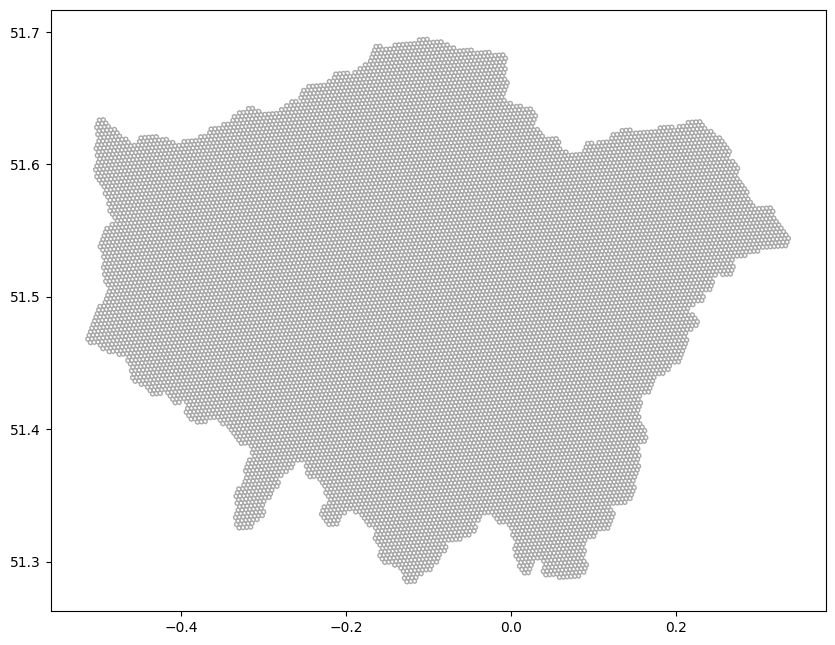

In [ ]:
LDN.plot(figsize = (10,15), facecolor = "None", edgecolor = "darkgray")
plt.show()

In [ ]:
LDN.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17636 entries, 0 to 17635
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   _index    17636 non-null  object  
 1   city      17636 non-null  object  
 2   index_h3  17636 non-null  object  
 3   geometry  17636 non-null  geometry
dtypes: geometry(1), object(3)
memory usage: 551.2+ KB


In [ ]:
#transform london to BNG
LDN.to_crs("EPSG:27700", inplace = True)

In [ ]:
#look under the bonnet
LDN.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

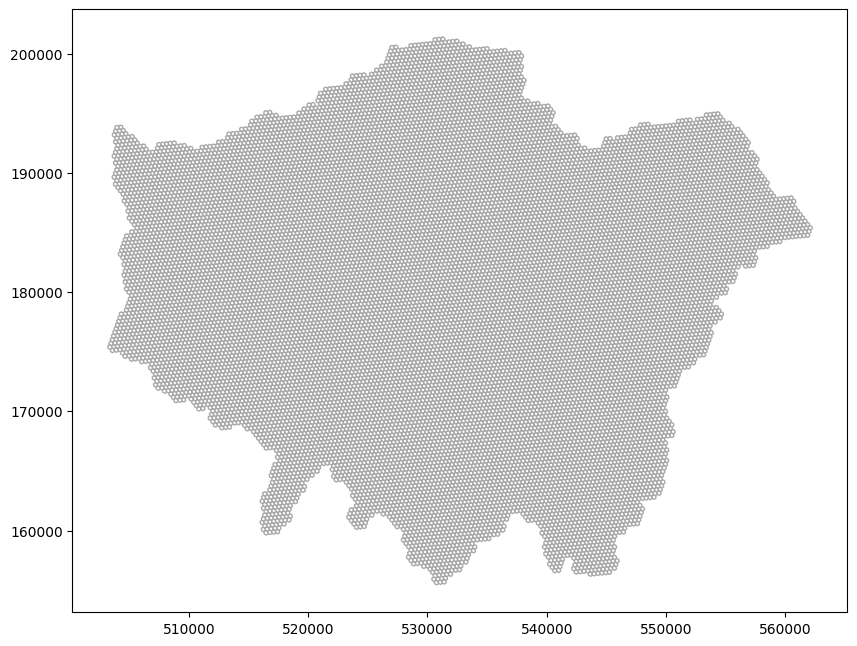

In [ ]:
#transform london to BNG
LDN.to_crs("EPSG:27700", inplace = True)
#We can check that this has occured by plotting the results
LDN.plot(figsize = (10,15), facecolor = "None", edgecolor = "darkgray")
plt.show()

In [ ]:
LDN.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [ ]:
LDN

,_index,city,index_h3,geometry
0,89195da6d73ffff,GL,89195da6d73ffff,"POLYGON ((533028.494 187118.372, 532886.249 18..."
1,89195d3643bffff,GL,89195d3643bffff,"POLYGON ((508897.279 178209.647, 508754.461 17..."
2,89194e6c17bffff,GL,89194e6c17bffff,"POLYGON ((552051.909 174548.828, 551909.995 17..."
3,89194e69263ffff,GL,89194e69263ffff,"POLYGON ((532184.826 190873.184, 532042.586 19..."
4,89194ada627ffff,GL,89194ada627ffff,"POLYGON ((522777.239 179004.450, 522634.723 17..."
...,...,...,...,...
17631,89194e6c5d3ffff,GL,89194e6c5d3ffff,"POLYGON ((553332.671 178220.444, 553190.807 17..."
17632,89194ac0507ffff,GL,89194ac0507ffff,"POLYGON ((532861.596 160198.176, 532719.181 16..."
17633,89194e69b8fffff,GL,89194e69b8fffff,"POLYGON ((536855.056 183955.545, 536712.873 18..."
17634,89194adaed3ffff,GL,89194adaed3ffff,"POLYGON ((524260.812 175308.640, 524118.305 17..."


## **Change from level 9 to level 8**

In [ ]:
# Assuming you already have the 'LDN' GeoDataFrame with H3 hexagons at level 9

# Function to convert a single hexagon from level 9 to level 8 and get the geometry
def convert_to_resolution_8_with_geometry(hex_id):
    # Convert hex ID from level 9 to level 8
    new_hex_id = h3.h3_to_parent(hex_id, 8)
    # Get the geometry of the new hexagon at level 8 (in lat-lon coordinates)
    geometry = h3.h3_to_geo_boundary(new_hex_id, geo_json=True)
    # Create a Polygon from the coordinates
    return new_hex_id, Polygon(geometry)

# Apply the function to the GeoDataFrame to get the new hex IDs and geometries at level 8
LDN['_index_res_8'], LDN['geometry_res_8'] = zip(*LDN['_index'].apply(convert_to_resolution_8_with_geometry))

# Convert the GeoDataFrame to EPSG:27700
LDN = gpd.GeoDataFrame(LDN, geometry='geometry_res_8', crs="EPSG:4326")  # Setting CRS to WGS84

# Reproject the GeoDataFrame to EPSG:27700
LDN = LDN.to_crs("EPSG:27700")

# Now, the 'LDN_res_8' GeoDataFrame contains the hexagons at level 8 with reprojected geometry in EPSG:27700.



In [ ]:
# Drop the original '_index' column if you want
LDN.drop(columns=['_index', 'city', 'index_h3', 'geometry'], inplace=True)


LDN = LDN.rename(columns={'_index_res_8': '_index'})

#REMOVE DUPLICATES

LDN = LDN.drop_duplicates(subset=['_index'], keep='first')

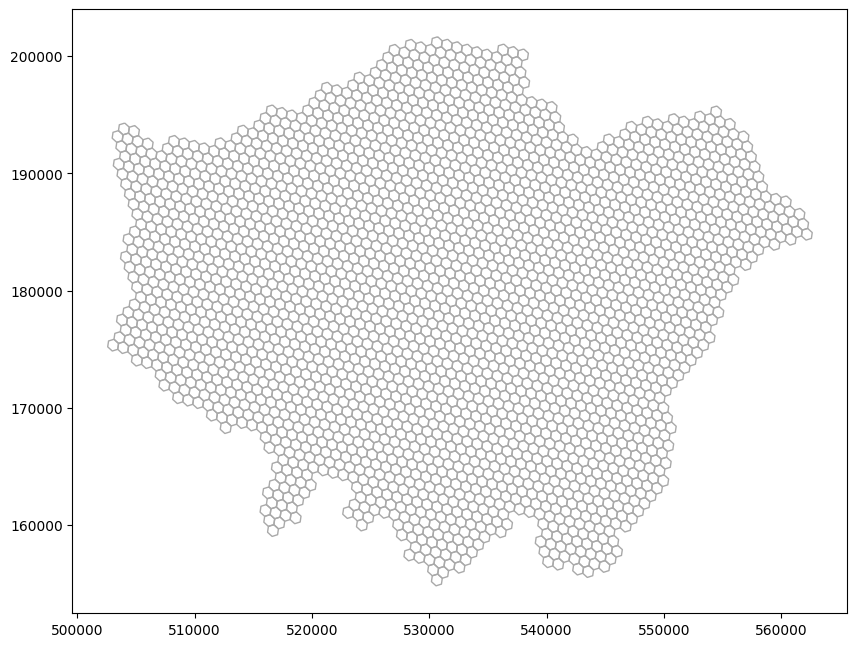

In [ ]:
#transform london to BNG
LDN.to_crs("EPSG:27700", inplace = True)
#We can check that this has occured by plotting the results
LDN.plot(figsize = (10,15), facecolor = "None", edgecolor = "darkgray")
plt.show()

In [ ]:
#order it by borough code - *This step will be important later on*
LDN.sort_values(by=["_index"], inplace = True)

#extract the centroids
LDN["Centroids"] = LDN.geometry.centroid



In [ ]:
# set the index
London = LDN
London.set_index('_index', inplace=True, drop=True)

#calculate distances from all Hex centroids to all Hex centroids
distances = London.rename_axis('Orig').Centroids.apply(lambda x: London.rename_axis('Dest').Centroids.distance(x)).stack().reset_index()
distances.rename(columns = {0:'Dist'}, inplace=True)
distances.sort_values(by=["Orig", "Dest"], inplace = True)
London.reset_index(inplace=True)

London

,_index,geometry_res_8,Centroids
0,88194ac001fffff,"POLYGON ((530516.565 160553.007, 530054.079 16...",POINT (530444.262 160052.357)
1,88194ac003fffff,"POLYGON ((530834.462 159697.152, 530371.979 15...",POINT (530762.165 159196.473)
2,88194ac005fffff,"POLYGON ((529663.876 160762.807, 529201.343 16...",POINT (529591.550 160262.141)
3,88194ac007fffff,"POLYGON ((529981.774 159906.920, 529519.243 15...",POINT (529909.454 159406.225)
4,88194ac009fffff,"POLYGON ((531051.292 161199.022, 530588.851 16...",POINT (530979.008 160698.415)
...,...,...,...
2620,88195db6b3fffff,"POLYGON ((536141.740 199527.826, 535680.353 19...",POINT (536069.780 199029.086)
2621,88195db6b5fffff,"POLYGON ((534973.430 200592.378, 534511.993 20...",POINT (534901.441 200093.653)
2622,88195db6b7fffff,"POLYGON ((535290.906 199738.800, 534829.471 19...",POINT (535218.923 199240.045)
2623,88195db6b9fffff,"POLYGON ((536357.557 201023.872, 535896.212 20...",POINT (536285.611 200525.207)


In [ ]:
# Save the GeoDataFrame to a JSON file
LDN.to_file(path + 'grid7.json', driver='GeoJSON')

TypeError: ignored

# **Population**

In [ ]:
#Load Population dataset
population_gdf = pd.read_csv(path + "population.csv")

In [ ]:
borough = London_ex_raw.copy()

#the data needs to be ordered by borough code, if it's not then we will run into problems when we try to merge the
#distance data back in later
borough.sort_values(by=["NAME"], inplace = True)

In [ ]:
#reset the resulting index (important for later) when merging back together
borough.reset_index(inplace=True)
borough.drop(columns = ["index"], inplace=True)

In [ ]:
#  drop columns

population_gdf = population_gdf.drop(['cod'], axis=1)

#the data needs to be ordered by borough code, if it's not then we will run into problems when we try to merge the
#distance data back in later
population_gdf.sort_values(by=["borough"], inplace = True)

#reset the resulting index (important for later) when merging back together
population_gdf.reset_index(inplace=True)
population_gdf.drop(columns = ["index"], inplace=True)

population_gdf

,borough,population
0,Barking and Dagenham,"218,900"
1,Barnet,"389,300"
2,Bexley,"246,500"
3,Brent,"339,800"
4,Bromley,"330,000"
5,Camden,"210,100"
6,City of London,"8,600"
7,Croydon,"390,800"
8,Ealing,"367,100"
9,Enfield,"330,000"


In [ ]:
merged_gdf = borough.merge(population_gdf, left_index=True, right_index=True)

In [ ]:
# Drop the original '_index' column if you want
merged_gdf.drop(columns=['GSS_CODE', 'HECTARES', 'NONLD_AREA', 'ONS_INNER', 'SUB_2009', 'SUB_2006', 'borough'], inplace=True)

In [ ]:
# Convert the column from object to integer
merged_gdf['population'] = merged_gdf['population'].str.replace(',', '').astype(int)

In [ ]:
merged_gdf.info(0)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NAME        33 non-null     object  
 1   geometry    33 non-null     geometry
 2   population  33 non-null     int64   
dtypes: geometry(1), int64(1), object(1)
memory usage: 920.0+ bytes


In [ ]:
London7

,_index,geometry
0,87195da6dffffff,"POLYGON ((533244.756 188616.370, 532249.060 18..."
1,87195d364ffffff,"POLYGON ((508582.379 179953.595, 507582.599 17..."
2,87194e6c1ffffff,"POLYGON ((552585.636 176078.867, 551592.306 17..."
3,87194e692ffffff,"POLYGON ((532508.265 192676.567, 531512.635 19..."
4,87194ada6ffffff,"POLYGON ((522036.690 181295.751, 521038.989 18..."
...,...,...
410,87194e616ffffff,"POLYGON ((548895.695 196365.305, 547902.698 19..."
411,87194ac2dffffff,"POLYGON ((538403.739 160166.970, 537407.586 15..."
412,87194e6a5ffffff,"POLYGON ((546663.674 196144.293, 545670.330 19..."
413,87194ac12ffffff,"POLYGON ((521986.454 162651.785, 520987.942 16..."


In [ ]:
population_gdf = merged_gdf
grid_gdf = London7

population_gdf['oa_area'] = population_gdf.area

# Projecting the population data onto the hexagonal grid
population_gdf = gpd.overlay(grid_gdf, population_gdf, how='intersection')
population_gdf['oa_ratio'] = population_gdf.area / population_gdf.oa_area
population_gdf['population'] = population_gdf.population * population_gdf.oa_ratio
population_gdf = population_gdf[['_index', 'population']].groupby('_index').sum().sort_values(by='population', ascending=False)
population_gdf = gpd.GeoDataFrame(grid_gdf[['_index', 'geometry']].merge(population_gdf, on='_index'))

# Drop the original '_index' column if you want
#intersections.drop(columns=['geometry_res_8'], inplace=True)

population_gdf

<ipython-input-16-5e19b9ad5a84>:7: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OS ...

  population_gdf = gpd.overlay(grid_gdf, population_gdf, how='intersection')


,_index,geometry,population
0,87195da6dffffff,"POLYGON ((533244.756 188616.370, 532249.060 18...",60279.651485
1,87195d364ffffff,"POLYGON ((508582.379 179953.595, 507582.599 17...",12290.980472
2,87194e6c1ffffff,"POLYGON ((552585.636 176078.867, 551592.306 17...",7288.640906
3,87194e692ffffff,"POLYGON ((532508.265 192676.567, 531512.635 19...",34284.547355
4,87194ada6ffffff,"POLYGON ((522036.690 181295.751, 521038.989 18...",47778.208237
...,...,...,...
401,87195da0dffffff,"POLYGON ((519094.602 197549.505, 518097.164 19...",385.066674
402,87194ac85ffffff,"POLYGON ((516746.801 160049.669, 515747.392 15...",85.185734
403,87194ad41ffffff,"POLYGON ((547350.389 161072.222, 546355.620 16...",125.980708
404,87194e616ffffff,"POLYGON ((548895.695 196365.305, 547902.698 19...",81.388924


In [ ]:
population_gdf.drop(columns=['geometry'], inplace=True)

In [ ]:
population_gdf

,_index,population
0,87195da6dffffff,60279.651485
1,87195d364ffffff,12290.980472
2,87194e6c1ffffff,7288.640906
3,87194e692ffffff,34284.547355
4,87194ada6ffffff,47778.208237
...,...,...
401,87195da0dffffff,385.066674
402,87194ac85ffffff,85.185734
403,87194ad41ffffff,125.980708
404,87194e616ffffff,81.388924


In [ ]:
#order it by borough code - *This step will be important later on*
London7.sort_values(by=["_index"], inplace = True)

#extract the centroids
London7["Centroids"] = London7.geometry.centroid



In [ ]:
# set the index
London = London7
London.set_index('_index', inplace=True, drop=True)

#calculate distances from all Hex centroids to all Hex centroids
distances = London.rename_axis('Orig').Centroids.apply(lambda x: London.rename_axis('Dest').Centroids.distance(x)).stack().reset_index()
distances.rename(columns = {0:'Dist'}, inplace=True)
distances.sort_values(by=["Orig", "Dest"], inplace = True)
London.reset_index(inplace=True)

London

,_index,geometry,Centroids
0,87194ac00ffffff,"POLYGON ((530198.675 161408.835, 529201.343 16...",POINT (530444.193 160052.310)
1,87194ac01ffffff,"POLYGON ((531687.078 159487.402, 530689.887 15...",POINT (531932.646 158130.811)
2,87194ac02ffffff,"POLYGON ((527958.284 161182.457, 526960.606 16...",POINT (528203.746 159825.736)
3,87194ac03ffffff,"POLYGON ((529446.920 159260.759, 528449.383 15...",POINT (529692.431 157903.971)
4,87194ac04ffffff,"POLYGON ((530950.217 163556.354, 529953.090 16...",POINT (531195.743 162200.092)
...,...,...,...
410,87195db5bffffff,"POLYGON ((525811.072 198212.705, 524814.675 19...",POINT (526056.262 196859.377)
411,87195db5cffffff,"POLYGON ((527312.727 202492.207, 526316.744 20...",POINT (527557.932 201139.413)
412,87195db5dffffff,"POLYGON ((528799.155 200573.363, 527803.312 19...",POINT (529044.412 199220.499)
413,87195db69ffffff,"POLYGON ((537741.407 201455.283, 536746.951 20...",POINT (537986.901 200103.204)


In [ ]:
distances = distances.rename(columns={'Orig': 'ORIGIN_CODE',
                                      'Dest': 'DESTINATION_CODE'})

In [ ]:
distances.drop(columns=['ORIGIN_CODE'], inplace=True)

In [ ]:
distances = distances.rename(columns={'DESTINATION_CODE': '_index'})

In [ ]:
# Grouping by 'DESTINATION_CODE' and summing the 'FLOWS' column
dist_final = distances.groupby('_index')['Dist'].sum().reset_index()

In [ ]:
dist_final

,_index,Dist
0,87194ac00ffffff,1.010858e+07
1,87194ac01ffffff,1.069579e+07
2,87194ac02ffffff,1.025381e+07
3,87194ac03ffffff,1.079716e+07
4,87194ac04ffffff,9.482477e+06
...,...,...
410,87195db5bffffff,9.849426e+06
411,87195db5cffffff,1.106896e+07
412,87195db5dffffff,1.039602e+07
413,87195db69ffffff,1.097868e+07


In [ ]:
# Merge the dataframes based on the index ['ORIGIN_CODE', 'DESTINATION_CODE']
population_final = pd.merge(London7, population_gdf, on=['_index'], how= 'left').fillna(0)

In [ ]:
population_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 415 entries, 0 to 414
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   _index      415 non-null    object  
 1   geometry    415 non-null    geometry
 2   Centroids   415 non-null    geometry
 3   population  415 non-null    float64 
dtypes: float64(1), geometry(2), object(1)
memory usage: 16.2+ KB


In [ ]:
population_final.drop(columns=['Centroids'], inplace=True)

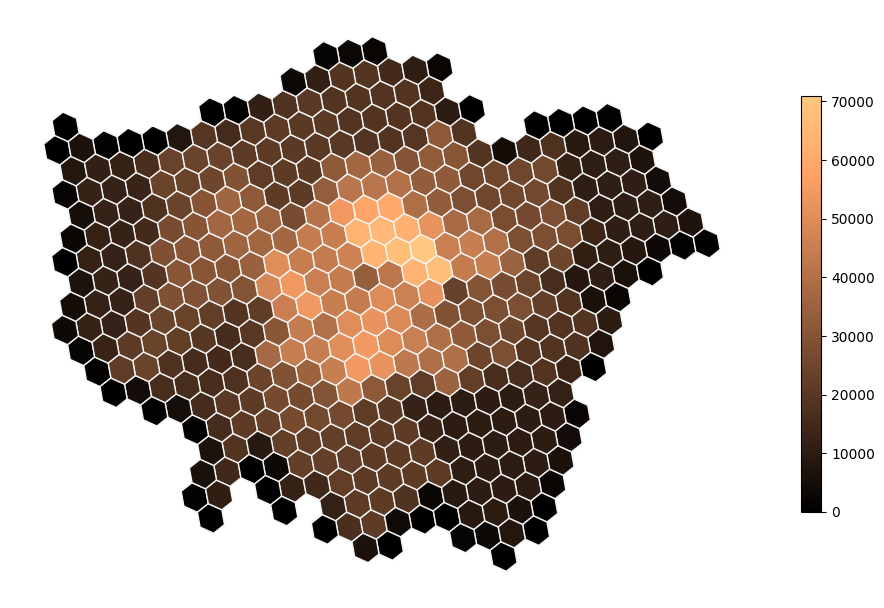

In [ ]:
#transform london to BNG
population_final.to_crs("EPSG:27700", inplace = True)
#We can check that this has occured by plotting the results
population_final.plot(figsize = (12,9), column='population', edgecolor='whitesmoke', cmap = 'copper',legend=True, legend_kwds={'shrink': 0.6})
plt.axis('off')
plt.savefig(path + "images/population.png", bbox_inches = 'tight')

In [ ]:
# Drop the original '_index' column if you want
population_final.drop(columns=['geometry_res_8'], inplace=True)

In [ ]:
population_final

,_index,population
0,88194ac001fffff,2995.992551
1,88194ac003fffff,2996.134943
2,88194ac005fffff,3015.140711
3,88194ac007fffff,2996.508644
4,88194ac009fffff,2995.476462
...,...,...
2620,88195db6b3fffff,2646.739239
2621,88195db6b5fffff,1374.489908
2622,88195db6b7fffff,2647.067379
2623,88195db6b9fffff,0.000000


In [ ]:
population_final.to_csv(path + 'pop.csv', index=False)

# **SIM_Leasure and Care**

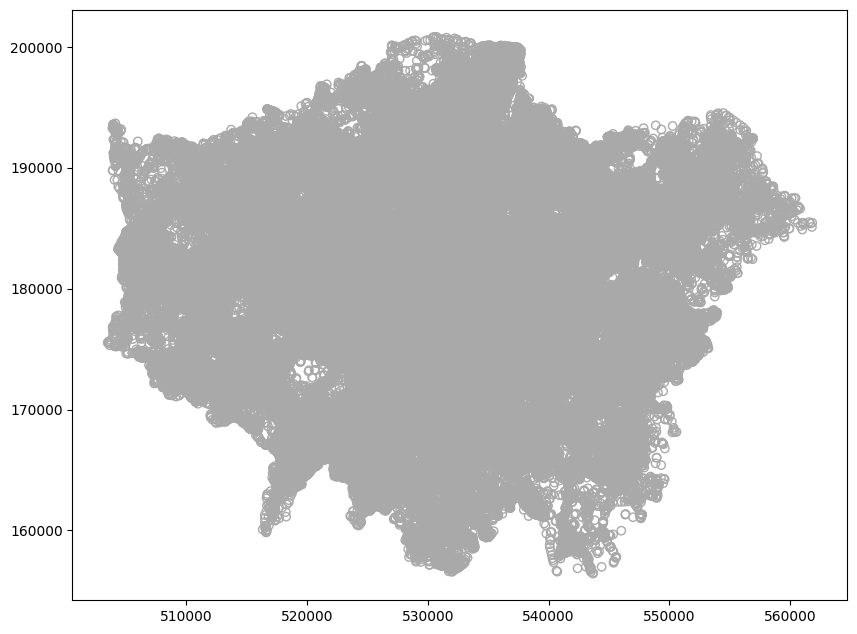

In [ ]:
POI_LC = POI.copy()

POI_LC.plot(figsize = (10,15), facecolor = "None", edgecolor = "darkgray")
plt.show()

**check merge poi and hex**

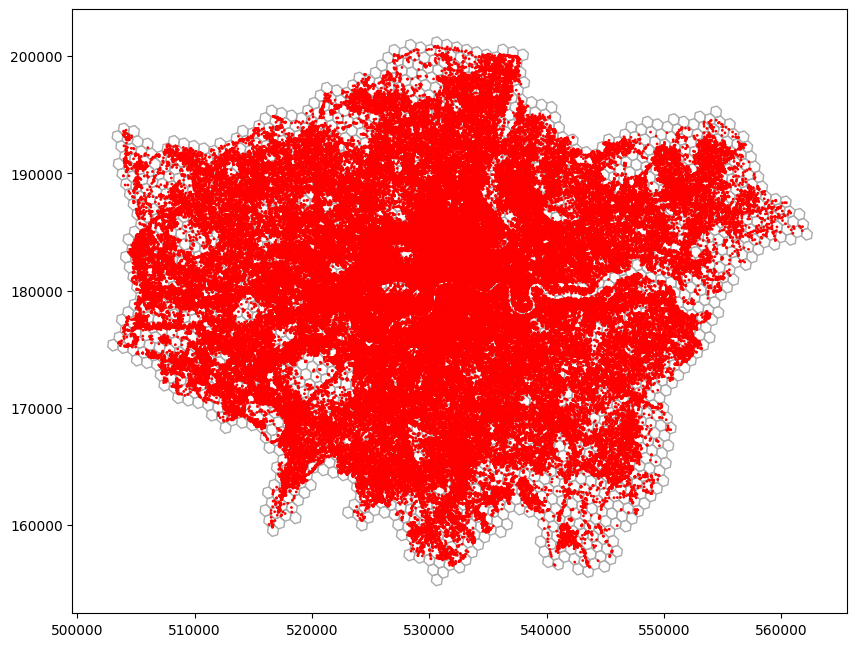

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,15))

#transform london to BNG
POI_LC.to_crs("EPSG:27700", inplace = True)
LDN.to_crs("EPSG:27700", inplace = True)

#We can check that this has occured by plotting the results
LDN.plot(facecolor = "None", edgecolor = "darkgray", ax=ax)
POI_LC.plot(cmap='Greens', markersize=1, facecolor = "None", edgecolor = "r", ax=ax)

plt.show()

In [ ]:
# pick the columns that we need
POI_LC = POI_LC.loc[:,['groupname','feature_easting','feature_northing', 'geometry']]
POI_LC.columns

# Spatial join the points to the polygons
POIHEX = gpd.sjoin(POI_LC, LDN, how='inner', op='within')

# Reset the index to have the points indexed by the polygons' index
POIHEX = POIHEX.reset_index(drop=True)

#  drop columns

LeisureCare = POIHEX.drop(['feature_easting', 'feature_northing', 'index_right'], axis=1)

LeisureCare

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,groupname,geometry,_index
0,Transport,POINT (559498.000 184352.000),88194e6095fffff
1,Transport,POINT (559508.000 184343.000),88194e6095fffff
2,Commercial Services,POINT (559505.000 184295.000),88194e6095fffff
3,Commercial Services,POINT (559506.000 184295.000),88194e6095fffff
4,Attractions,POINT (531404.000 196330.000),88195db4bdfffff
...,...,...,...
342375,Transport,POINT (546452.000 189996.000),88194e6aebfffff
342376,Transport,POINT (508791.000 184307.000),88195dac33fffff
342377,Transport,POINT (509265.000 184277.000),88195dac33fffff
342378,Transport,POINT (548866.000 193521.000),88194e6129fffff


In [ ]:
#  drop columns

df_LeisureCare = LeisureCare.drop(['geometry'], axis=1)

# Pivot the DataFrame
df_LeisureCare = df_LeisureCare.pivot_table(index='_index', columns='groupname', aggfunc='size', fill_value=0)

#  drop columns

df_LeisureCare = df_LeisureCare.drop(['Manufacturing and Production', 'Public Infrastructure', 'Transport','Commercial Services'], axis=1)

# Set '_index' as the first column
df_LeisureCare.reset_index(inplace=True)

# List of columns to be summed
columns_to_sum = ['Accommodation, Eating and Drinking', 'Attractions',
                  'Education and Health', 'Retail', 'Sport and Entertainment']

# Create the new column 'all' by summing the values of the specified columns
df_LeisureCare['all'] = df_LeisureCare[columns_to_sum].sum(axis=1)


# Move the 'all' column to position 1
all_column = df_LeisureCare.pop('all')
df_LeisureCare.insert(1, 'all', all_column)

df_LeisureCare

groupname,_index,all,"Accommodation, Eating and Drinking",Attractions,Commercial Services,Education and Health,Retail,Sport and Entertainment
0,88194ac001fffff,35,1,0,17,11,3,3
1,88194ac003fffff,17,1,1,5,4,3,3
2,88194ac005fffff,27,0,0,16,9,1,1
3,88194ac007fffff,235,43,6,108,19,51,8
4,88194ac009fffff,65,6,1,34,15,6,3
...,...,...,...,...,...,...,...,...
2526,88195db6b3fffff,104,15,0,48,15,24,2
2527,88195db6b5fffff,27,6,2,11,1,6,1
2528,88195db6b7fffff,29,0,2,20,4,3,0
2529,88195db6b9fffff,0,0,0,0,0,0,0


In [ ]:
# creating the final version

df_lc_final = df_LeisureCare.drop(['Accommodation, Eating and Drinking', 'Attractions',
                  'Education and Health', 'Retail', 'Sport and Entertainment'], axis=1)

In [ ]:
df_lc_final.to_csv(path + 'POI_leisurecare.csv', index=False)

In [ ]:
df_lc_final

groupname,_index,all
0,88194ac001fffff,60
1,88194ac003fffff,39
2,88194ac005fffff,39
3,88194ac007fffff,332
4,88194ac009fffff,117
...,...,...
2526,88195db6b3fffff,145
2527,88195db6b5fffff,57
2528,88195db6b7fffff,53
2529,88195db6b9fffff,3


# **SIM_Work**

In [ ]:
JOBS = pd.read_csv('https://data.london.gov.uk/download/jobs-and-job-density-borough/79e85749-e38d-4bb6-8327-c60c6be27222/Jobs_and_Job_Density.csv')

In [ ]:
JOBS

,code,area,year,number_of_jobs,job_density
0,E09000001,City of London,2000,361000,67.10
1,E09000002,Barking and Dagenham,2000,57000,0.56
2,E09000003,Barnet,2000,138000,0.67
3,E09000004,Bexley,2000,76000,0.55
4,E09000005,Brent,2000,122000,0.67
...,...,...,...,...,...
1073,N92000002,Northern Ireland,2021,894000,0.75
1074,E92000001,England,2021,30664000,0.86
1075,K04000001,England and Wales,2021,32123000,0.86
1076,K03000001,Great Britain,2021,34957000,0.85


In [ ]:
#subset daily

df_jobs = JOBS[(JOBS['year'] == 2021)][['area', 'number_of_jobs', 'code']]

#the data needs to be ordered by borough code, if it's not then we will run into problems when we try to merge the
#distance data back in later
df_jobs.sort_values(by=["area"], inplace = True)

# Filter rows where the 'code' column contains 'E09'
df_jobs = df_jobs[df_jobs['code'].str.contains('E09')]

# Reset the index to have the points indexed by the polygons' index
df_jobs = df_jobs.reset_index(drop=True)

#rename column
df_jobs = df_jobs.rename(columns={'number_of_jobs': 'jobs'})
#drop columns
df_jobs = df_jobs.drop(['code'], axis=1)

df_jobs

,area,jobs
0,Barking and Dagenham,72000
1,Barnet,176000
2,Bexley,87000
3,Brent,147000
4,Bromley,124000
5,Camden,418000
6,City of London,673000
7,Croydon,142000
8,Ealing,158000
9,Enfield,123000


In [ ]:
borough = London_ex_raw.copy()

# Reset the index and move the old index as a new column
#borough.reset_index(inplace=True)

#Merge dataframes

merged_gdf = borough.merge(df_jobs, left_index=True, right_index=True)

# Drop the original '_index' column if you want
merged_gdf.drop(columns=['GSS_CODE', 'HECTARES', 'NONLD_AREA', 'ONS_INNER', 'SUB_2009', 'SUB_2006','area'], inplace=True)

merged_gdf


,NAME,geometry,jobs
0,Kingston upon Thames,"POLYGON ((516401.600 160201.800, 516407.300 16...",72000
1,Croydon,"POLYGON ((535009.200 159504.700, 535005.500 15...",176000
2,Bromley,"POLYGON ((540373.600 157530.400, 540361.200 15...",87000
3,Hounslow,"POLYGON ((521975.800 178100.000, 521967.700 17...",147000
4,Ealing,"POLYGON ((510253.500 182881.600, 510249.900 18...",124000
5,Havering,"POLYGON ((549893.900 181459.800, 549894.600 18...",418000
6,Hillingdon,"POLYGON ((510599.800 191689.500, 510615.200 19...",673000
7,Harrow,"POLYGON ((510599.800 191689.500, 510660.000 19...",142000
8,Brent,"POLYGON ((525201.000 182512.600, 525181.500 18...",158000
9,Barnet,"POLYGON ((524579.900 198355.200, 524594.300 19...",123000


In [ ]:
jobs_gdf = merged_gdf
grid_gdf = LDN

jobs_gdf['oa_area'] = jobs_gdf.area

# Projecting the population data onto the hexagonal grid
intersections = gpd.overlay(grid_gdf, jobs_gdf, how='intersection')
intersections['oa_ratio'] = intersections.area / intersections.oa_area
intersections['jobs'] = intersections.jobs * intersections.oa_ratio
intersections = intersections[['_index', 'jobs']].groupby('_index').sum().sort_values(by='jobs', ascending=False)
intersections = gpd.GeoDataFrame(grid_gdf[['_index', 'geometry_res_8']].merge(intersections, on='_index'))

# Drop the original '_index' column if you want
#intersections.drop(columns=['geometry_res_8'], inplace=True)

intersections

<ipython-input-136-d39c588c5be7>:7: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OS ...

  intersections = gpd.overlay(grid_gdf, jobs_gdf, how='intersection')


,_index,geometry_res_8,jobs
0,88195da6d7fffff,"POLYGON ((533028.494 187118.372, 532566.674 18...",3329.453623
1,88195d3643fffff,"POLYGON ((509217.896 178241.664, 508754.461 17...",3863.183306
2,88194e6c17fffff,"POLYGON ((552370.882 174580.849, 551909.995 17...",124.280418
3,88194e6927fffff,"POLYGON ((532291.994 191179.056, 531830.209 19...",6939.145011
4,88194ada63fffff,"POLYGON ((522672.113 179585.288, 522209.519 17...",3595.649181
...,...,...,...
2573,88195dade1fffff,"POLYGON ((504431.379 184865.541, 503967.782 18...",33.958418
2574,88194e6a53fffff,"POLYGON ((547298.670 194437.800, 546837.861 19...",2.375357
2575,88194ac12bfffff,"POLYGON ((523157.688 161585.689, 522694.776 16...",98.611578
2576,88194ad59dfffff,"POLYGON ((543616.165 156552.728, 543154.398 15...",1.761222


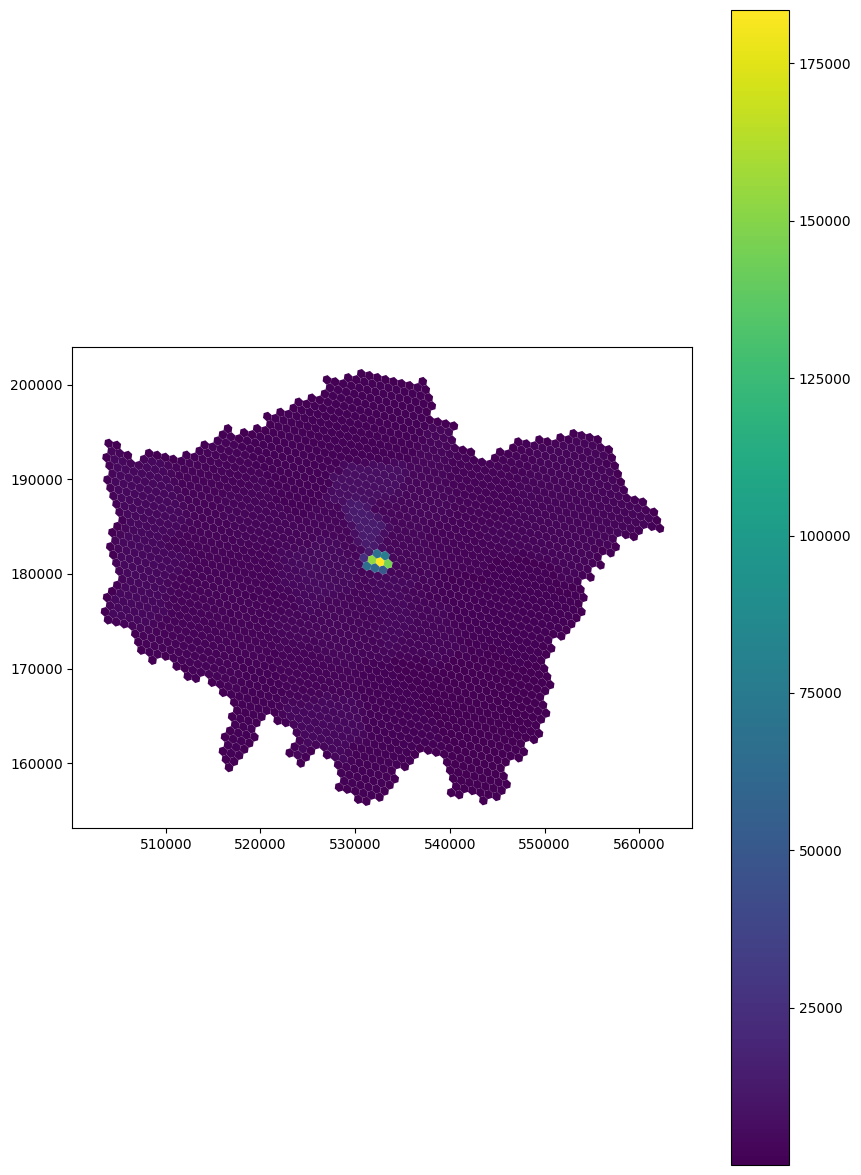

In [ ]:
LDN = intersections

#transform london to BNG
LDN.to_crs("EPSG:27700", inplace = True)
#We can check that this has occured by plotting the results
LDN.plot(figsize = (10,15), column='jobs', legend=True)
plt.show()

In [ ]:
# Drop the original '_index' column if you want
intersections.drop(columns=['geometry_res_8'], inplace=True)

In [ ]:
intersections.to_csv(path + 'jobs.csv', index=False)

# **Flow Data - Leisure/Care**

**DATA WRANGLING**

In [ ]:
od2 = pd.read_csv(path + "Audience_Profiles_Destination_2023-03-12.tsv", sep="\t", low_memory=False)

KeyboardInterrupt: ignored

In [ ]:
od2

,DESTINATION_CODE,ORIGIN_CODE,TIME INTERVAL,DAY,DAY_TYPE,MONTH,YEAR,MOVEMENT_MODALITY,VISITATION_MODALITY,NUMBER_OF_USERS,NUMBER_OF_SIGNALS,DWELL_TIME,EXTRAPOLATED_NUMBER_OF_USERS,EXTRAPOLATED_NUMBER_OF_SIGNALS,PROPORTION_OF_USERS
0,89195dae2b7ffff,89195dae2b7ffff,0,2023-03-12,7,3,2023,ALL,WORKERS,3.0,5.0,2.310830,69.0,115.0,0.053571
1,89195da62b7ffff,89195da62b7ffff,0,2023-03-12,7,3,2023,ALL,WORKERS,4.0,13.0,1.776044,92.0,300.0,0.090909
2,89195da62b3ffff,89195da62b3ffff,0,2023-03-12,7,3,2023,ALL,WORKERS,4.0,12.0,2.446954,92.0,277.0,0.129032
3,89195da62bbffff,89195da62bbffff,0,2023-03-12,7,3,2023,ALL,WORKERS,2.0,20.0,8.575581,46.0,461.0,0.008130
4,89195dae2bbffff,89195dae2bbffff,0,2023-03-12,7,3,2023,ALL,WORKERS,2.0,3.0,1.787488,46.0,69.0,0.035088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8750724,89194e6c5cfffff,0,6,2023-03-12,7,3,2023,PEDESTRIANS,ALL,0.0,0.0,0.000000,0.0,0.0,0.000000
8750725,89194e6c5cbffff,0,6,2023-03-12,7,3,2023,PEDESTRIANS,ALL,0.0,0.0,0.000000,0.0,0.0,0.000000
8750726,89195d3448bffff,0,6,2023-03-12,7,3,2023,PEDESTRIANS,ALL,0.0,0.0,0.000000,0.0,0.0,0.000000
8750727,89195d34493ffff,0,6,2023-03-12,7,3,2023,PEDESTRIANS,ALL,0.0,0.0,0.000000,0.0,0.0,0.000000


In [ ]:
od = pd.read_csv(path + "Audience_Profiles_Destination_2023-03-12.tsv", sep="\t", low_memory=False)

#subset daily

daily_OD = od[(od['TIME INTERVAL'] == 25) & (od.MOVEMENT_MODALITY=='ALL')][['ORIGIN_CODE', 'DESTINATION_CODE', 'EXTRAPOLATED_NUMBER_OF_USERS', 'VISITATION_MODALITY']]



#create pivot table and replace nan with 0 and rename index as index

pivot = daily_OD.pivot_table(

    index=['ORIGIN_CODE', 'DESTINATION_CODE'],

    columns='VISITATION_MODALITY',

    values='EXTRAPOLATED_NUMBER_OF_USERS',

    aggfunc='sum').fillna(0).reset_index()



pivot.columns.name = None



pivot['TRANSIENTS'] =  pivot['ALL'] - pivot['WORKERS']

In [ ]:
pivot

,ORIGIN_CODE,DESTINATION_CODE,ALL,WORKERS,TRANSIENTS
0,0,89194aca35bffff,0.0,0.0,0.0
1,0,89194ad4013ffff,0.0,0.0,0.0
2,0,89194ad4017ffff,0.0,0.0,0.0
3,0,89194ad406fffff,0.0,0.0,0.0
4,0,89194ad40a7ffff,0.0,0.0,0.0
...,...,...,...,...,...
494618,891976d80b3ffff,89194ac148bffff,23.0,23.0,0.0
494619,891976d80b3ffff,89194ac3267ffff,23.0,0.0,23.0
494620,891976d80b3ffff,89194ac3663ffff,23.0,0.0,23.0
494621,891976d80b3ffff,89194ac366fffff,23.0,0.0,23.0


In [ ]:
# Convert 'ORIGIN_CODE' column to string
pivot['ORIGIN_CODE'] = pivot['ORIGIN_CODE'].astype(str)

# Remove rows with value '0' in 'ORIGIN_CODE'
OD1 = pivot[pivot['ORIGIN_CODE'] != '0']

In [ ]:
OD1

,ORIGIN_CODE,DESTINATION_CODE,ALL,WORKERS,TRANSIENTS
68,8909a6b65dbffff,89194ada017ffff,23.0,23.0,0.0
69,89182180447ffff,89194ada097ffff,23.0,0.0,23.0
70,89182180447ffff,89195da490fffff,23.0,0.0,23.0
71,89182180447ffff,89195da4b63ffff,23.0,0.0,23.0
72,89182180697ffff,89194ad2933ffff,23.0,0.0,23.0
...,...,...,...,...,...
494618,891976d80b3ffff,89194ac148bffff,23.0,23.0,0.0
494619,891976d80b3ffff,89194ac3267ffff,23.0,0.0,23.0
494620,891976d80b3ffff,89194ac3663ffff,23.0,0.0,23.0
494621,891976d80b3ffff,89194ac366fffff,23.0,0.0,23.0


In [ ]:
od = pd.read_csv(path + "Audience_Profiles_Origin_2023-03-12.tsv", sep="\t", low_memory=False)

#subset daily

daily_OD = od[(od['TIME INTERVAL'] == 25) & (od.MOVEMENT_MODALITY=='ALL')][['ORIGIN_CODE', 'DESTINATION_CODE', 'EXTRAPOLATED_NUMBER_OF_USERS', 'VISITATION_MODALITY']]



#create pivot table and replace nan with 0 and rename index as index

pivot = daily_OD.pivot_table(

    index=['ORIGIN_CODE', 'DESTINATION_CODE'],

    columns='VISITATION_MODALITY',

    values='EXTRAPOLATED_NUMBER_OF_USERS',

    aggfunc='sum').fillna(0).reset_index()



pivot.columns.name = None



pivot['TRANSIENTS'] =  pivot['ALL'] - pivot['WORKERS']

In [ ]:
# Convert 'ORIGIN_CODE' column to string
pivot['DESTINATION_CODE'] = pivot['DESTINATION_CODE'].astype(str)

# Remove rows with value '0' in 'ORIGIN_CODE'
OD2 = pivot[pivot['DESTINATION_CODE'] != '0']

#check the results

OD2

,ORIGIN_CODE,DESTINATION_CODE,ALL,WORKERS,TRANSIENTS
0,89194ac0003ffff,89194ac0003ffff,92.0,92.0,0.0
1,89194ac0003ffff,89194ac0403ffff,23.0,0.0,23.0
2,89194ac0003ffff,89194ac040bffff,23.0,0.0,23.0
3,89194ac0003ffff,89194ac0473ffff,23.0,0.0,23.0
4,89194ac0003ffff,89194ac0613ffff,23.0,0.0,23.0
...,...,...,...,...,...
232549,89195db6bbbffff,89194e79dbbffff,46.0,0.0,46.0
232550,89195db6bbbffff,89195da6137ffff,0.0,23.0,-23.0
232551,89195db6bbbffff,89195db6b17ffff,92.0,0.0,92.0
232552,89195db6bbbffff,89195db6bbbffff,92.0,0.0,92.0


In [ ]:
# Merge the dataframes based on the index ['ORIGIN_CODE', 'DESTINATION_CODE']
merged_df = pd.merge(OD1, OD2, on=['ORIGIN_CODE', 'DESTINATION_CODE'], suffixes=('_OD1', '_OD2'))

# Sum the specified columns ['ALL', 'WORKERS', 'TRANSIENTS']
float_columns = ['ALL', 'WORKERS', 'TRANSIENTS']
for col in float_columns:
    merged_df[col] = merged_df[f'{col}_OD1'] + merged_df[f'{col}_OD2']

merged_df

,ORIGIN_CODE,DESTINATION_CODE,ALL_OD1,WORKERS_OD1,TRANSIENTS_OD1,ALL_OD2,WORKERS_OD2,TRANSIENTS_OD2,ALL,WORKERS,TRANSIENTS
0,89194ac0003ffff,89194ac0003ffff,92.0,92.0,0.0,92.0,92.0,0.0,184.0,184.0,0.0
1,89194ac0003ffff,89194ac0403ffff,23.0,0.0,23.0,23.0,0.0,23.0,46.0,0.0,46.0
2,89194ac0003ffff,89194ac040bffff,23.0,0.0,23.0,23.0,0.0,23.0,46.0,0.0,46.0
3,89194ac0003ffff,89194ac0473ffff,23.0,0.0,23.0,23.0,0.0,23.0,46.0,0.0,46.0
4,89194ac0003ffff,89194ac0613ffff,23.0,0.0,23.0,23.0,0.0,23.0,46.0,0.0,46.0
...,...,...,...,...,...,...,...,...,...,...,...
191905,89195db6bbbffff,89194e60a53ffff,23.0,23.0,0.0,0.0,23.0,-23.0,23.0,46.0,-23.0
191906,89195db6bbbffff,89194e6b65bffff,23.0,23.0,0.0,0.0,23.0,-23.0,23.0,46.0,-23.0
191907,89195db6bbbffff,89195da6137ffff,0.0,23.0,-23.0,0.0,23.0,-23.0,0.0,46.0,-46.0
191908,89195db6bbbffff,89195db6b17ffff,92.0,0.0,92.0,92.0,0.0,92.0,184.0,0.0,184.0


In [ ]:
merged_df[merged_df.ALL_OD1==0]

,ORIGIN_CODE,DESTINATION_CODE,ALL_OD1,WORKERS_OD1,TRANSIENTS_OD1,ALL_OD2,WORKERS_OD2,TRANSIENTS_OD2,ALL,WORKERS,TRANSIENTS
81,89194ac0023ffff,89194ac0027ffff,0.0,23.0,-23.0,0.0,23.0,-23.0,0.0,46.0,-46.0
99,89194ac002bffff,89194ad19b3ffff,0.0,23.0,-23.0,0.0,23.0,-23.0,0.0,46.0,-46.0
127,89194ac003bffff,89194ac0177ffff,0.0,23.0,-23.0,0.0,23.0,-23.0,0.0,46.0,-46.0
161,89194ac0053ffff,89194ac23a3ffff,0.0,23.0,-23.0,0.0,23.0,-23.0,0.0,46.0,-46.0
162,89194ac0053ffff,89194ad12cfffff,0.0,23.0,-23.0,0.0,23.0,-23.0,0.0,46.0,-46.0
...,...,...,...,...,...,...,...,...,...,...,...
191854,89195db6b8fffff,89194ad8c83ffff,0.0,23.0,-23.0,0.0,23.0,-23.0,0.0,46.0,-46.0
191855,89195db6b8fffff,89195da45c7ffff,0.0,23.0,-23.0,0.0,23.0,-23.0,0.0,46.0,-46.0
191866,89195db6ba7ffff,89194e68467ffff,0.0,23.0,-23.0,0.0,23.0,-23.0,0.0,46.0,-46.0
191867,89195db6ba7ffff,89194e69523ffff,0.0,23.0,-23.0,0.0,23.0,-23.0,0.0,46.0,-46.0


In [ ]:
# Drop the redundant columns if needed
merged_df.drop(columns=[f'{col}_OD1' for col in float_columns], inplace=True)
merged_df.drop(columns=[f'{col}_OD2' for col in float_columns], inplace=True)
merged_df

,ORIGIN_CODE,DESTINATION_CODE,ALL,WORKERS,TRANSIENTS
0,89194ac0003ffff,89194ac0003ffff,184.0,184.0,0.0
1,89194ac0003ffff,89194ac0403ffff,46.0,0.0,46.0
2,89194ac0003ffff,89194ac040bffff,46.0,0.0,46.0
3,89194ac0003ffff,89194ac0473ffff,46.0,0.0,46.0
4,89194ac0003ffff,89194ac0613ffff,46.0,0.0,46.0
...,...,...,...,...,...
191905,89195db6bbbffff,89194e60a53ffff,23.0,46.0,-23.0
191906,89195db6bbbffff,89194e6b65bffff,23.0,46.0,-23.0
191907,89195db6bbbffff,89195da6137ffff,0.0,46.0,-46.0
191908,89195db6bbbffff,89195db6b17ffff,184.0,0.0,184.0


In [ ]:
merged_df['TRANSIENTS'] = merged_df['TRANSIENTS'].apply(lambda x: max(0, x))

In [ ]:
merged_df

,ORIGIN_CODE,DESTINATION_CODE,ALL,WORKERS,TRANSIENTS
0,89194ac0003ffff,89194ac0003ffff,184.0,184.0,0.0
1,89194ac0003ffff,89194ac0403ffff,46.0,0.0,46.0
2,89194ac0003ffff,89194ac040bffff,46.0,0.0,46.0
3,89194ac0003ffff,89194ac0473ffff,46.0,0.0,46.0
4,89194ac0003ffff,89194ac0613ffff,46.0,0.0,46.0
...,...,...,...,...,...
191905,89195db6bbbffff,89194e60a53ffff,23.0,46.0,0.0
191906,89195db6bbbffff,89194e6b65bffff,23.0,46.0,0.0
191907,89195db6bbbffff,89195da6137ffff,0.0,46.0,0.0
191908,89195db6bbbffff,89195db6b17ffff,184.0,0.0,184.0


In [ ]:
#  drop columns

OD = merged_df.drop(['ALL','WORKERS'], axis=1)

In [ ]:
OD = OD.rename(columns={'TRANSIENTS': 'FLOWS'})

In [ ]:
OD

,ORIGIN_CODE,DESTINATION_CODE,FLOWS
0,89194ac0003ffff,89194ac0003ffff,0.0
1,89194ac0003ffff,89194ac0403ffff,46.0
2,89194ac0003ffff,89194ac040bffff,46.0
3,89194ac0003ffff,89194ac0473ffff,46.0
4,89194ac0003ffff,89194ac0613ffff,46.0
...,...,...,...
191905,89195db6bbbffff,89194e60a53ffff,0.0
191906,89195db6bbbffff,89194e6b65bffff,0.0
191907,89195db6bbbffff,89195da6137ffff,0.0
191908,89195db6bbbffff,89195db6b17ffff,184.0


**Change to Hexagon level 8**

In [ ]:
# Assuming 'ORIGIN_CODE' and 'DESTINATION_CODE' are H3 level 9 indices (hexagons)
# You can create a new column with H3 level 8 indices based on the level 9 indices
OD['ORIGIN_CODE_LEVEL_8'] = OD['ORIGIN_CODE'].apply(lambda x: h3.h3_to_parent(x, 8))
OD['DESTINATION_CODE_LEVEL_8'] = OD['DESTINATION_CODE'].apply(lambda x: h3.h3_to_parent(x, 8))

# Group by the new level 8 indices and sum the 'FLOWS' values
aggregated_OD = OD.groupby(['ORIGIN_CODE_LEVEL_8', 'DESTINATION_CODE_LEVEL_8'])['FLOWS'].sum().reset_index()

# Drop the intermediate columns if you don't need them anymore
# aggregated_OD.drop(['ORIGIN_CODE','DESTINATION_CODE'], axis=1)

# Rename the columns to match your original DataFrame if necessary
aggregated_OD.rename(columns={'ORIGIN_CODE_LEVEL_8': 'ORIGIN_CODE', 'DESTINATION_CODE_LEVEL_8': 'DESTINATION_CODE'}, inplace=True)

# Now, aggregated_OD contains the desired result with H3 level 8 indices and aggregated 'FLOWS' values
aggregated_OD

,ORIGIN_CODE,DESTINATION_CODE,FLOWS
0,88194ac001fffff,88194ac001fffff,2440.0
1,88194ac001fffff,88194ac003fffff,368.0
2,88194ac001fffff,88194ac007fffff,1288.0
3,88194ac001fffff,88194ac009fffff,782.0
4,88194ac001fffff,88194ac00dfffff,92.0
...,...,...,...
77751,88195db6bbfffff,88195db4d9fffff,414.0
77752,88195db6bbfffff,88195db6b1fffff,598.0
77753,88195db6bbfffff,88195db6b3fffff,920.0
77754,88195db6bbfffff,88195db6b5fffff,230.0


In [ ]:
aggregated_OD

,ORIGIN_CODE,DESTINATION_CODE,FLOWS
0,88194ac001fffff,88194ac001fffff,2440.0
1,88194ac001fffff,88194ac003fffff,368.0
2,88194ac001fffff,88194ac007fffff,1288.0
3,88194ac001fffff,88194ac009fffff,782.0
4,88194ac001fffff,88194ac00dfffff,92.0
...,...,...,...
77751,88195db6bbfffff,88195db4d9fffff,414.0
77752,88195db6bbfffff,88195db6b1fffff,598.0
77753,88195db6bbfffff,88195db6b3fffff,920.0
77754,88195db6bbfffff,88195db6b5fffff,230.0


In [ ]:
aggregated_OD.to_csv('/content/drive/My Drive/Colab/OD_locomizer_level8.csv', index=False)

# **Flow Data - Work**

In [ ]:
od = pd.read_csv(path + "Audience_Profiles_Destination_2023-03-08.tsv", sep="\t", low_memory=False)

ParserError: ignored

In [ ]:
#subset daily

daily_OD = od[(od['TIME INTERVAL'] == 25) & (od.MOVEMENT_MODALITY=='ALL')][['ORIGIN_CODE', 'DESTINATION_CODE', 'EXTRAPOLATED_NUMBER_OF_USERS', 'VISITATION_MODALITY']]



#create pivot table and replace nan with 0 and rename index as index

pivot = daily_OD.pivot_table(

    index=['ORIGIN_CODE', 'DESTINATION_CODE'],

    columns='VISITATION_MODALITY',

    values='EXTRAPOLATED_NUMBER_OF_USERS',

    aggfunc='sum').fillna(0).reset_index()



pivot.columns.name = None



#pivot['TRANSIENTS'] =  pivot['ALL'] - pivot['WORKERS']

In [ ]:
# Convert 'ORIGIN_CODE' column to string
pivot['DESTINATION_CODE'] = pivot['DESTINATION_CODE'].astype(str)

# Remove rows with value '0' in 'ORIGIN_CODE'
OD3 = pivot[pivot['DESTINATION_CODE'] != '0']

#check the results

OD3

,ORIGIN_CODE,DESTINATION_CODE,ALL,WORKERS
0,0,89194ac2ea3ffff,0.0,0.0
1,0,89194ac2ed7ffff,0.0,0.0
2,0,89194ad51c3ffff,0.0,0.0
3,0,89194ad51cbffff,0.0,0.0
4,0,89194ad51dbffff,0.0,0.0
...,...,...,...,...
611991,891976d80b3ffff,89194ac365bffff,21.0,0.0
611992,891976d80b3ffff,89194ac3663ffff,21.0,0.0
611993,891976d80b3ffff,89194ad1023ffff,21.0,0.0
611994,891976d80b3ffff,89194ad10abffff,21.0,0.0


In [ ]:
od = pd.read_csv(path + "Audience_Profiles_Origin_2023-03-08.tsv", sep="\t", low_memory=False)

In [ ]:
#subset daily

daily_OD = od[(od['TIME INTERVAL'] == 25) & (od.MOVEMENT_MODALITY=='ALL')][['ORIGIN_CODE', 'DESTINATION_CODE', 'EXTRAPOLATED_NUMBER_OF_USERS', 'VISITATION_MODALITY']]



#create pivot table and replace nan with 0 and rename index as index

pivot = daily_OD.pivot_table(

    index=['ORIGIN_CODE', 'DESTINATION_CODE'],

    columns='VISITATION_MODALITY',

    values='EXTRAPOLATED_NUMBER_OF_USERS',

    aggfunc='sum').fillna(0).reset_index()



pivot.columns.name = None



#pivot['TRANSIENTS'] =  pivot['ALL'] - pivot['WORKERS']

In [ ]:
# Convert 'ORIGIN_CODE' column to string
pivot['DESTINATION_CODE'] = pivot['DESTINATION_CODE'].astype(str)

# Remove rows with value '0' in 'ORIGIN_CODE'
OD4 = pivot[pivot['DESTINATION_CODE'] != '0']

#check the results

OD4

,ORIGIN_CODE,DESTINATION_CODE,ALL,WORKERS
0,89194ac0003ffff,89194ac0003ffff,64.0,64.0
1,89194ac0003ffff,89194ac000bffff,21.0,0.0
2,89194ac0003ffff,89194ac001bffff,21.0,0.0
3,89194ac0003ffff,89194ac006bffff,21.0,0.0
4,89194ac0003ffff,89194ac0073ffff,21.0,0.0
...,...,...,...,...
2918586,89195db6bbbffff,89195db6bb3ffff,21.0,0.0
2918587,89195db6bbbffff,89195db6bb7ffff,42.0,0.0
2918588,89195db6bbbffff,89195db6bbbffff,85.0,0.0
2918589,89195db6bbbffff,89195db6bcbffff,21.0,0.0


In [ ]:
# Merge the dataframes based on the index ['ORIGIN_CODE', 'DESTINATION_CODE']
merged_df = pd.merge(OD3, OD4, on=['ORIGIN_CODE', 'DESTINATION_CODE'], suffixes=('_OD3', '_OD4'))

# Sum the specified columns ['ALL', 'WORKERS', 'TRANSIENTS']
float_columns = ['ALL', 'WORKERS']
for col in float_columns:
    merged_df[col] = merged_df[f'{col}_OD3'] + merged_df[f'{col}_OD4']

merged_df

,ORIGIN_CODE,DESTINATION_CODE,ALL_OD3,WORKERS_OD3,ALL_OD4,WORKERS_OD4,ALL,WORKERS
0,89194ac0003ffff,89194ac0003ffff,64.0,64.0,64.0,64.0,128.0,128.0
1,89194ac0003ffff,89194ac000bffff,21.0,0.0,21.0,0.0,42.0,0.0
2,89194ac0003ffff,89194ac001bffff,21.0,0.0,21.0,0.0,42.0,0.0
3,89194ac0003ffff,89194ac006bffff,21.0,0.0,21.0,0.0,42.0,0.0
4,89194ac0003ffff,89194ac0073ffff,21.0,0.0,21.0,0.0,42.0,0.0
...,...,...,...,...,...,...,...,...
281980,89195db6bbbffff,89194e6b65bffff,0.0,21.0,21.0,21.0,21.0,42.0
281981,89195db6bbbffff,89195db6b17ffff,42.0,0.0,42.0,0.0,84.0,0.0
281982,89195db6bbbffff,89195db6babffff,42.0,0.0,42.0,0.0,84.0,0.0
281983,89195db6bbbffff,89195db6bb7ffff,42.0,0.0,42.0,0.0,84.0,0.0


In [ ]:
# Drop the redundant columns if needed
merged_df.drop(columns=[f'{col}_OD3' for col in float_columns], inplace=True)
merged_df.drop(columns=[f'{col}_OD4' for col in float_columns], inplace=True)
merged_df

,ORIGIN_CODE,DESTINATION_CODE,ALL,WORKERS
0,89194ac0003ffff,89194ac0003ffff,128.0,128.0
1,89194ac0003ffff,89194ac000bffff,42.0,0.0
2,89194ac0003ffff,89194ac001bffff,42.0,0.0
3,89194ac0003ffff,89194ac006bffff,42.0,0.0
4,89194ac0003ffff,89194ac0073ffff,42.0,0.0
...,...,...,...,...
281980,89195db6bbbffff,89194e6b65bffff,21.0,42.0
281981,89195db6bbbffff,89195db6b17ffff,84.0,0.0
281982,89195db6bbbffff,89195db6babffff,84.0,0.0
281983,89195db6bbbffff,89195db6bb7ffff,84.0,0.0


In [ ]:
merged_df[merged_df.WORKERS==0]

,ORIGIN_CODE,DESTINATION_CODE,ALL,WORKERS
1,89194ac0003ffff,89194ac000bffff,42.0,0.0
2,89194ac0003ffff,89194ac001bffff,42.0,0.0
3,89194ac0003ffff,89194ac006bffff,42.0,0.0
4,89194ac0003ffff,89194ac0073ffff,42.0,0.0
5,89194ac0003ffff,89194ac007bffff,42.0,0.0
...,...,...,...,...
281977,89195db6bb3ffff,89195db6b8fffff,42.0,0.0
281981,89195db6bbbffff,89195db6b17ffff,84.0,0.0
281982,89195db6bbbffff,89195db6babffff,84.0,0.0
281983,89195db6bbbffff,89195db6bb7ffff,84.0,0.0


In [ ]:
#  drop columns

OD = merged_df.drop(['ALL'], axis=1)

In [ ]:
OD = OD.rename(columns={'WORKERS': 'FLOWS'})

In [ ]:
OD

,ORIGIN_CODE,DESTINATION_CODE,FLOWS
0,89194ac0003ffff,89194ac0003ffff,128.0
1,89194ac0003ffff,89194ac000bffff,0.0
2,89194ac0003ffff,89194ac001bffff,0.0
3,89194ac0003ffff,89194ac006bffff,0.0
4,89194ac0003ffff,89194ac0073ffff,0.0
...,...,...,...
281980,89195db6bbbffff,89194e6b65bffff,42.0
281981,89195db6bbbffff,89195db6b17ffff,0.0
281982,89195db6bbbffff,89195db6babffff,0.0
281983,89195db6bbbffff,89195db6bb7ffff,0.0


In [ ]:
# Assuming 'ORIGIN_CODE' and 'DESTINATION_CODE' are H3 level 9 indices (hexagons)
# You can create a new column with H3 level 8 indices based on the level 9 indices
OD['ORIGIN_CODE_LEVEL_8'] = OD['ORIGIN_CODE'].apply(lambda x: h3.h3_to_parent(x, 8))
OD['DESTINATION_CODE_LEVEL_8'] = OD['DESTINATION_CODE'].apply(lambda x: h3.h3_to_parent(x, 8))

# Group by the new level 8 indices and sum the 'FLOWS' values
aggregated_OD = OD.groupby(['ORIGIN_CODE_LEVEL_8', 'DESTINATION_CODE_LEVEL_8'])['FLOWS'].sum().reset_index()

# Drop the intermediate columns if you don't need them anymore
# aggregated_OD.drop(['ORIGIN_CODE','DESTINATION_CODE'], axis=1)

# Rename the columns to match your original DataFrame if necessary
aggregated_OD.rename(columns={'ORIGIN_CODE_LEVEL_8': 'ORIGIN_CODE', 'DESTINATION_CODE_LEVEL_8': 'DESTINATION_CODE'}, inplace=True)

# Now, aggregated_OD contains the desired result with H3 level 8 indices and aggregated 'FLOWS' values
aggregated_OD

,ORIGIN_CODE,DESTINATION_CODE,FLOWS
0,88194ac001fffff,88194ac001fffff,2914.0
1,88194ac001fffff,88194ac003fffff,0.0
2,88194ac001fffff,88194ac007fffff,0.0
3,88194ac001fffff,88194ac009fffff,0.0
4,88194ac001fffff,88194ac00bfffff,0.0
...,...,...,...
114243,88195db6bbfffff,88195db6b1fffff,0.0
114244,88195db6bbfffff,88195db6b3fffff,0.0
114245,88195db6bbfffff,88195db6b5fffff,0.0
114246,88195db6bbfffff,88195db6b9fffff,0.0


In [ ]:
aggregated_OD.to_csv(path + 'OD_level8_work.csv', index=False)

# **DG_Features**

**Load packages and data**

In [ ]:
df = POI.copy()

# locomizer hexagon grid at level 8
LDN = gpd.read_file(path + 'grid7.json')

In [ ]:
# pick the columns that we need
POI = df.loc[:,['groupname','categoryname','classname', 'geometry']]
POI.columns

Index(['groupname', 'categoryname', 'classname', 'geometry'], dtype='object')

In [ ]:
POI = POI[POI['groupname'] != 'Manufacturing and Production']

**1. TRANSPORT[4]**

0.   Bus Transport [categoryname]
1.   Public Transport, Stations and Infrastructure [categoryname]
2.   'Water' [categoryname]
3.   'Air' [categoryname]

In [ ]:
# TRANSPORT

#remove categoryname not utilised
POI = POI[POI['categoryname'] != 'Road and Rail']
POI = POI[POI['categoryname'] != 'Walking']



In [ ]:
# Define the mapping of substrings to 'new definition' in a dictionary
category_mapping = {
    'Bus Transport': '0_Bus',
    'Public Transport, Stations and Infrastructure': '1_Stations_Infrastructure',
    'Water': '2_Water',
    'Air': '3_Air'
    # Add more mappings as needed
}

# Define a function to check if any of the substrings are present in the 'categoryname'
# and return the corresponding 'new definition'
def check_category(row):
    for substring, definition in category_mapping.items():
        if substring in row['categoryname']:
            return definition
    return ''

# Apply the function to create the 'features' column
POI['features'] = POI.apply(check_category, axis=1)

In [ ]:
POI['features'].unique().tolist()

['0_Bus', '', '2_Water', '1_Stations_Infrastructure', '3_Air']

**2_EDUCATION AND HEALTH[2]**
4.  Education [new]
5.  Health [new]

In [ ]:
# Define the mapping of substrings to 'new definition' in a dictionary
category_mapping = {
    'Recreational and Vocational Education': '4_Education',
    'Primary, Secondary and Tertiary Education': '4_Education',
    'Education Support Services': '4_Education',
    'Health Support Services': '5_Health',
    'Health Practitioners and Establishments': '5_Health',
    'Animal Welfare': '5_Health'

    # Add more mappings as needed
}

# Define a function to check if any of the substrings are present in the 'categoryname'
# and update the 'features' column accordingly
def update_features(row):
    for substring, definition in category_mapping.items():
        if substring in row['categoryname']:
            return definition
    return row['features']

# Apply the function to update the 'features' column
POI['features'] = POI.apply(update_features, axis=1)

In [ ]:
POI['features'].unique().tolist()

['0_Bus',
 '',
 '5_Health',
 '4_Education',
 '2_Water',
 '1_Stations_Infrastructure',
 '3_Air']

**3_Accommodation, Eating and Drinking[5]**
6.   Accomodation [new]
7.   Restaurants [classname]
8.   Fast Food [new]
9.  Pubs, Bars and Inns [classname]
10.  Cafes, Snack Bars and Tea Rooms [new]

In [ ]:
# Define the mapping of substrings to 'new definition' in a dictionary
category_mapping = {
    'Banqueting and Function Rooms': '6_Accomodation',
    'Camping, Caravanning, Mobile Homes, Holiday Parks and Centres': '6_Accomodation',
    'Hostels and Refuges For The Homeless': '6_Accomodation',
    'Bed and Breakfast and Backpacker Accommodation': '6_Accomodation',
    'Youth Accommodation': '6_Accomodation',
    'Self Catering': '6_Accomodationn',
    'Hotels, Motels, Country Houses and Inns': '6_Accomodation',
    'Timeshare': '6_Accomodation',
    'Restaurants': '7_Restaurants',
    'Fast Food and Takeaway Outlets': '8_Fast_Food',
    'Fish and Chip Shops': '8_Fast_Food',
    'Fast Food Delivery Services': '8_Fast_Food',
    'Pubs, Bars and Inns': '9_Pubs',
    'Cafes, Snack Bars and Tea Rooms': '10_Cafes',
    'Internet Cafes': '10_Cafes'
    # Add more mappings as needed
}

# Define a function to check if any of the substrings are present in the 'categoryname'
# and update the 'features' column accordingly
def update_features(row):
    for substring, definition in category_mapping.items():
        if substring in row['classname']:
            return definition
    return row['features']

# Apply the function to update the 'features' column
POI['features'] = POI.apply(update_features, axis=1)

In [ ]:
POI['features'].unique().tolist()

['0_Bus',
 '',
 '5_Health',
 '7_Restaurants',
 '6_Accomodation',
 '4_Education',
 '2_Water',
 '1_Stations_Infrastructure',
 '6_Accomodationn',
 '9_Pubs',
 '10_Cafes',
 '8_Fast_Food',
 '3_Air']

**4_RETAIL AND SERVICES[2]**

11.  Retail[groupname]
12.  Commercial Services [groupname]

In [ ]:
# Define the mapping of substrings to 'new definition' in a dictionary
category_mapping = {
    'Retail': '11_Retail',
    'Commercial Services': '12_Commercial_Services'
    # Add more mappings as needed
}

# Define a function to check if any of the substrings are present in the 'categoryname'
# and update the 'features' column accordingly
def update_features(row):
    for substring, definition in category_mapping.items():
        if substring in row['groupname']:
            return definition
    return row['features']

# Apply the function to update the 'features' column
POI['features'] = POI.apply(update_features, axis=1)


In [ ]:
POI['features'].unique().tolist()

['0_Bus',
 '',
 '5_Health',
 '12_Commercial_Services',
 '7_Restaurants',
 '6_Accomodation',
 '4_Education',
 '2_Water',
 '1_Stations_Infrastructure',
 '11_Retail',
 '6_Accomodationn',
 '9_Pubs',
 '10_Cafes',
 '8_Fast_Food',
 '3_Air']

**5_LEISURE[2]**
13.  Sport and Entertainment[groupname]
14.  Atractions [groupname]

In [ ]:
# Define the mapping of substrings to 'new definition' in a dictionary
category_mapping = {
    'Sport and Entertainment': '13_Sport_Entertainment',
    'Attractions': '14_Attractions'
    # Add more mappings as needed
}

# Define a function to check if any of the substrings are present in the 'categoryname'
# and update the 'features' column accordingly
def update_features(row):
    for substring, definition in category_mapping.items():
        if substring in row['groupname']:
            return definition
    return row['features']

# Apply the function to update the 'features' column
POI['features'] = POI.apply(update_features, axis=1)

In [ ]:
POI['features'].unique().tolist()

['0_Bus',
 '14_Attractions',
 '5_Health',
 '12_Commercial_Services',
 '',
 '7_Restaurants',
 '6_Accomodation',
 '4_Education',
 '2_Water',
 '1_Stations_Infrastructure',
 '11_Retail',
 '6_Accomodationn',
 '9_Pubs',
 '13_Sport_Entertainment',
 '10_Cafes',
 '8_Fast_Food',
 '3_Air']

**6_PUBLIC INFRASTRUCTURE[3]**
15. Infrastructure and Facilities [categoryname]
16. Central and Local Government [categoryname]
17. Organisations [categoryname]

In [ ]:
# Define the mapping of substrings to 'new definition' in a dictionary
category_mapping = {
    'Infrastructure and Facilities': '15_Facilities',
    'Central and Local Government': '16_Government',
    'Organisations': '17_Organisations'
    # Add more mappings as needed
}

# Define a function to check if any of the substrings are present in the 'categoryname'
# and update the 'features' column accordingly
def update_features(row):
    for substring, definition in category_mapping.items():
        if substring in row['categoryname']:
            return definition
    return row['features']

# Apply the function to update the 'features' column
POI['features'] = POI.apply(update_features, axis=1)

In [ ]:
POI['features'].unique().tolist()

['0_Bus',
 '14_Attractions',
 '5_Health',
 '12_Commercial_Services',
 '15_Facilities',
 '7_Restaurants',
 '6_Accomodation',
 '4_Education',
 '16_Government',
 '17_Organisations',
 '2_Water',
 '1_Stations_Infrastructure',
 '11_Retail',
 '6_Accomodationn',
 '9_Pubs',
 '13_Sport_Entertainment',
 '10_Cafes',
 '8_Fast_Food',
 '3_Air']

**Merge data**

In [ ]:
POI

,groupname,categoryname,classname,geometry,features
0,Transport,Bus Transport,Bus Stops,POINT (559498.000 184352.000),0_Bus
1,Attractions,Historical and Cultural,Historic and Ceremonial Structures,POINT (531404.000 196330.000),14_Attractions
2,Attractions,Historical and Cultural,Historic and Ceremonial Structures,POINT (524417.000 197646.000),14_Attractions
3,Attractions,Historical and Cultural,Historic and Ceremonial Structures,POINT (525419.000 189921.000),14_Attractions
4,Transport,Bus Transport,Bus Stops,POINT (537731.000 196190.000),0_Bus
...,...,...,...,...,...
342381,Public Infrastructure,Infrastructure and Facilities,Halls and Community Centres,POINT (522497.500 192819.000),15_Facilities
342382,Public Infrastructure,Infrastructure and Facilities,Halls and Community Centres,POINT (543777.000 184393.000),15_Facilities
342383,Public Infrastructure,Organisations,Youth Organisations,POINT (508075.000 186144.000),17_Organisations
342384,Public Infrastructure,Infrastructure and Facilities,Halls and Community Centres,POINT (517119.200 177291.200),15_Facilities


In [ ]:
# pick the columns that we need
POI_features = POI.loc[:,['features', 'geometry']]
POI_features.columns

Index(['features', 'geometry'], dtype='object')

In [ ]:
LDN = grid8

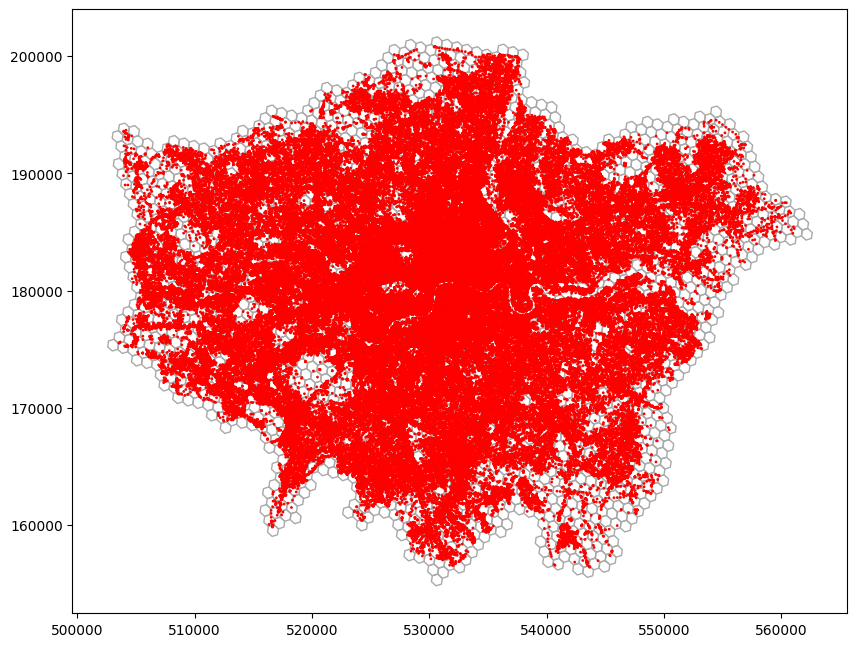

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,15))

#transform london to BNG
POI_features.to_crs("EPSG:27700", inplace = True)
LDN.to_crs("EPSG:27700", inplace = True)

#We can check that this has occured by plotting the results
LDN.plot(facecolor = "None", edgecolor = "darkgray", ax=ax)
POI_features.plot(cmap='Greens', markersize=1, facecolor = "None", edgecolor = "r", ax=ax)

plt.show()

In [ ]:
# Spatial join the points to the polygons
POI_features = gpd.sjoin(POI_features, LDN, how='inner', op='within')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
# Reset the index to have the points indexed by the polygons' index
POI_features = POI_features.reset_index(drop=True)

In [ ]:
POI_features

,features,geometry,index_right,_index
0,0_Bus,POINT (559498.000 184352.000),1649,88194e6095fffff
1,0_Bus,POINT (559508.000 184343.000),1649,88194e6095fffff
2,12_Commercial_Services,POINT (559505.000 184295.000),1649,88194e6095fffff
3,12_Commercial_Services,POINT (559506.000 184295.000),1649,88194e6095fffff
4,14_Attractions,POINT (531404.000 196330.000),996,88195db4bdfffff
...,...,...,...,...
318596,2_Water,POINT (552546.400 178867.700),717,88194e6c4bfffff
318597,2_Water,POINT (552611.000 178868.000),717,88194e6c4bfffff
318598,14_Attractions,POINT (509900.400 183835.900),2284,88195dacedfffff
318599,15_Facilities,POINT (536281.000 200097.000),1520,88195db6b9fffff


In [ ]:
#  drop columns

POI_features = POI_features.drop(['geometry', 'index_right'], axis=1)

# Pivot the DataFrame
POI_features = POI_features.pivot_table(index='_index', columns='features', aggfunc='size', fill_value=0)

# Set '_index' as the first column
POI_features.reset_index(inplace=True)



In [ ]:
POI_features.columns

Index(['_index', '0_Bus', '10_Cafes', '11_Retail', '12_Commercial_Services',
       '13_Sport_Entertainment', '14_Attractions', '15_Facilities',
       '16_Government', '17_Organisations', '1_Stations_Infrastructure',
       '2_Water', '3_Air', '4_Education', '5_Health', '6_Accomodation',
       '6_Accomodationn', '7_Restaurants', '8_Fast_Food', '9_Pubs'],
      dtype='object', name='features')

In [ ]:
# Rename Columns

POI_features = POI_features.rename(columns={
                          '0_Bus' : '0',
                          '1_Stations_Infrastructure' : '1',
                          '2_Water' : '2',
                          '3_Air' : '3',
                          '4_Education' : '4',
                          '5_Health' : '5',
                          '6_Accomodation' : '6',
                          '7_Restaurants' : '7',
                          '8_Fast_Food' : '8',
                          '9_Pubs' : '9',
                          '10_Cafes' : '10',
                          '11_Retail' : '11',
                          '12_Commercial_Services' : '12',
                          '13_Sport_Entertainment' : '13',
                          '14_Attractions' :'14',
                          '15_Facilities' : '15',
                          '16_Government' : '16',
                          '17_Organisations' : '17',
                          })

In [ ]:
# Get the column names that are numeric, excluding '_index'
numeric_columns = [col for col in POI_features.columns if col != 'GEOID' and col.isdigit()]

# Sort the numeric columns in numerical order
numeric_columns.sort(key=int)

# Reorder the columns with '_index' at position 0 followed by the sorted numeric columns
new_column_order = ['GEOID'] + numeric_columns

# Update the DataFrame with the new column order
POI_features = POI_features[new_column_order]


In [ ]:
POI_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   GEOID   2516 non-null   object
 1   0       2516 non-null   int64 
 2   1       2516 non-null   int64 
 3   2       2516 non-null   int64 
 4   3       2516 non-null   int64 
 5   4       2516 non-null   int64 
 6   5       2516 non-null   int64 
 7   6       2516 non-null   int64 
 8   7       2516 non-null   int64 
 9   8       2516 non-null   int64 
 10  9       2516 non-null   int64 
 11  10      2516 non-null   int64 
 12  11      2516 non-null   int64 
 13  12      2516 non-null   int64 
 14  13      2516 non-null   int64 
 15  14      2516 non-null   int64 
 16  15      2516 non-null   int64 
 17  16      2516 non-null   int64 
 18  17      2516 non-null   int64 
dtypes: int64(18), object(1)
memory usage: 373.6+ KB


In [ ]:
POI_features

features,GEOID,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,88194ac001fffff,10,0,0,0,3,8,0,0,1,0,0,3,17,3,0,12,0,1
1,88194ac003fffff,10,0,0,0,3,1,1,0,0,0,0,3,5,3,1,10,0,0
2,88194ac005fffff,4,0,0,0,5,4,0,0,0,0,0,1,16,1,0,6,0,0
3,88194ac007fffff,21,2,0,0,4,15,0,11,16,1,15,51,108,8,6,34,0,2
4,88194ac009fffff,10,1,0,0,5,10,0,1,4,0,1,6,34,3,1,24,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,88195db6b3fffff,11,1,0,0,10,5,0,2,7,1,5,24,48,2,0,23,0,1
2512,88195db6b5fffff,2,0,1,0,0,1,0,0,5,0,1,6,11,1,2,17,0,0
2513,88195db6b7fffff,2,1,0,0,3,1,0,0,0,0,0,3,20,0,2,18,0,0
2514,88195db6b9fffff,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
POI_features.to_csv('/content/drive/My Drive/Colab Notebooks/DeepGravity/deepgravity/data/london/features.csv', index=True)